<a href="https://colab.research.google.com/github/FrancescoMonaco/MultiDimMotifDiscovery/blob/main/Motif_Discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#@title Basics
!pip install numpy scikit-learn datasketch scipy
!pip install stumpy NearPy
%matplotlib inline
import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
from numba import cuda
from tqdm import tqdm
import multiprocessing as mp
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

#Development: Hash->Select->MinHash and variants

In [9]:
#@title Support functions
import numpy as np
from sklearn.random_projection import SparseRandomProjection
from nearpy import Engine
from nearpy.hashes import RandomDiscretizedProjections
from datasketch import MinHashLSH, MinHash
import pandas as pd
import matplotlib.pyplot as plt
import queue
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import multiprocessing
from itertools import combinations
import cProfile

class WindowedTS:
  def __init__(self, subsequences, window: int, rolling_avg, rolling_std):
    self.subsequences = subsequences
    self.w = window
    self.avgs = rolling_avg
    self.stds = rolling_std
    self.dimensionality = len(subsequences[0])

  def sub(self, i:int):
    return self.subsequences[i]

  def mean(self, i: int):
    return self.avgs[i]

  def std(self, i: int):
    return self.stds[i]

def euclidean_hash(data, rp):
  hash_str = rp.hash_vector(data)
  return list(map(int, hash_str[0].split('_')))

def z_normalized_euclidean_distance(ts1, ts2, indices, mean_ts1, std_ts1, mean_ts2, std_ts2):
    # Ensure both time series have the same dimensions
    if ts1.shape != ts2.shape:
        raise ValueError("Time series must have the same dimensions.")
    # Pick the dimensions used in this iteration
    ts1 = ts1[:,indices]
    ts2 = ts2[:,indices]

    '''
    # Calculate mean and standard deviation for each dimension
    mean_ts1 = np.mean(ts1, axis=0)
    std_ts1 = np.std(ts1, axis=0)

    mean_ts2 = np.mean(ts2, axis=0)
    std_ts2 = np.std(ts2, axis=0)
    '''
    # Z-normalize each dimension separately
    ts1_normalized = (ts1 - mean_ts1[indices]) / std_ts1[indices]
    ts2_normalized = (ts2 - mean_ts2[indices]) / std_ts2[indices]

    # Compute squared differences and sum them
    squared_diff_sum = np.sqrt(np.square(ts1_normalized - ts2_normalized))

    return np.sum(squared_diff_sum)

def minhash_signature(data, minhasher_seed, perm=64):
    minhasher = MinHash(num_perm=perm, seed=minhasher_seed)
    minhasher.update_batch(np.ascontiguousarray(data))

    return minhasher.copy()

def find_collisions(lsh, query_signature):
    # Query the LSH index for potential collisions
    result = lsh.query(query_signature)

    return result

def truncate(arr, cut):
  arr = arr[:len(arr)-1]
  return arr

def process_chunk(time_series, ranges, window, rp):
    mean_container = {}
    std_container = {}
    subsequences = []
    hash_mat = []

    for idx in ranges:
        hashed_sub = []
        subsequence = time_series[idx:idx+window]
        subsequences.append(subsequence.T)

        mean_container[idx] = np.mean(subsequence, axis=0)

        std_held = np.std(subsequence, axis=0)
        std_container[idx] = np.where(std_held == 0, 0.00001, std_held)

        subsequence_n = (subsequence - mean_container[idx]) / std_container[idx]
        for rp_temp in rp:
          hashed_sub.append(np.apply_along_axis(euclidean_hash, 0, subsequence_n, rp_temp))
        hash_mat.append(hashed_sub)



    return hash_mat, std_container, mean_container, subsequences


In [ ]:
#@title 1 Parallel S-RP-MP
def projection_cycle(i, all_indices_sets, subsequences, hashed_mat, top, dist_comp, window, lsh_threshold, lock):
    random_gen = np.random.default_rng()
    collided = False
    index_hash = 0
    already_comp = set()
    top = queue.PriorityQueue(maxsize=k+1)
    dist_comp = 0

  # For each column of the matrix
    for hashed_sub in hashed_mat:
      # Find num_comp random numbers between 0 and dimension of time series
      random_indices = [x for x in all_indices_sets]
      pj_ts = [subsequence[0][random_indices] for subsequence in hashed_sub]

      while not collided:
          if index_hash > 0:
              pj_ts= np.apply_along_axis(truncate, 1, pj_ts, 1)
          # Compute fingerprints
              # Create MinHash object
          minhash_seed = random_gen.integers(0, 2**32 - 1)
          minhash_signatures = []

          for projected_subsequence in pj_ts:
              minhash_sig = minhash_signature(projected_subsequence, minhash_seed)
              minhash_signatures.append(minhash_sig)
          lsh = MinHashLSH(threshold=lsh_threshold, num_perm=64)
          for ik, signature in enumerate(minhash_signatures):
              lsh.insert(ik, signature)

          for j, minhash_sig in enumerate(minhash_signatures):
                  collisions = lsh.query(minhash_sig)
                  #print(collisions)
                  if len(collisions) > 1:
                      collided = True
                      # Remove trivial matches, same subsequence or overlapping subsequences
                      collisions = [sorted((j, c)) for c in collisions if c != j and abs(c - j) > window]
                      #print(collisions)
                      curr_dist = 0

                      for collision in collisions:
                          add = True
                        # If we already computed this couple skip
                          if tuple(collision) in already_comp:
                            add=False
                            break
                        # If already inserted skip
                          if( any(collision == stored_el1 for _, (_, stored_el1) in top.queue)):
                              add = False
                              break
                          # Check overlap with the already computed
                          for stored in top.queue:
                            #Access the collision
                            stored_dist = abs(stored[0])
                            stored_el = stored[1]
                            stored_el1 = stored_el[1]
                            #stored = stored[1][0]
                            # If it's an overlap of both indices, keep the one with the smallest distance
                            if (abs(collision[0] - stored_el1[0]) < window or
                                abs(collision[1] - stored_el1[1]) < window):
                                curr_dist = z_normalized_euclidean_distance(subsequences[collision[0]], subsequences[collision[1]], random_indices)
                                if curr_dist < stored_dist:
                                  top.queue.remove(stored)
                                  top.put((-curr_dist, [dist_comp, collision]))
                                  already_comp.add(tuple(collision))
                                  add = False
                                  break

                          # Add to top with the projection index
                          if add:
                            dist_comp +=1
                            distance = z_normalized_euclidean_distance(subsequences[collision[0]], subsequences[collision[1]], random_indices)
                            top.put((-distance, [dist_comp , collision]))
                            already_comp.add(tuple(collision))
                            if top.full(): top.get(block=False)

          # Repeat with K-1 hashes
          if not collided:
              index_hash +=1

    return top, dist_comp


def pmotif_find(time_series, window, projection_iter, k, project_comp, bin_width, lsh_threshold, L, K):
    random_gen = np.random.default_rng()
  # Data
    dimension = time_series.shape[1]
    num_comp = project_comp
    top = queue.PriorityQueue(maxsize=(k+1))
  # Extract all subsequences
    subsequences = []
    hash_mat = []
    index_hash = 0
    dist_comp = 0
  # Hasher
    rp = []
    engines = []
    # Create the repetitions for the LSH
    for i in range(L):
      rps= RandomDiscretizedProjections('rp', K, bin_width)
      engine = Engine(window, lshashes=[rps])
      rp.append(rps)
      engines.append(engine)


  #Projection sets
    # Generate a pool of indices
    index_pool = combinations(range(dimension), project_comp)
    index_pool = [x for x in index_pool]
    # Shuffle the pool to ensure randomness
    random_gen.shuffle(index_pool)
    print(index_pool)

    for i in range(len(time_series) - window + 1):
        hashed_sub = []
        subsequence = time_series[i:i + window]
        subsequences.append(subsequence)
        subsequence = (subsequence - np.mean(subsequence)) / np.std(subsequence)
        for rp_temp in rp:
          hashed_sub.append(np.apply_along_axis(euclidean_hash, 0, subsequence, rp_temp))
        # Insert into the matrix at the corresponding row
        hash_mat.append(hashed_sub)
    hash_mat = list(map(list, zip(*hash_mat)))
    print("Hashing finished")
    lock = threading.Lock()

    with ThreadPoolExecutor() as executor:
      result = {executor.submit(projection_cycle, i, index_pool[i%len(index_pool)], subsequences, hash_mat, top, dist_comp, window, lsh_threshold, lock) for i in range(projection_iter)}
      with tqdm(total=projection_iter, desc="Iteration") as pbar:
        for future in as_completed(result):
          top_i, dist_comp_i = future.result()
          pbar.update(1)

          with lock:
            top.queue.extend(top_i.queue)
            dist_comp += dist_comp_i

            # Order the queue
            top.queue.sort(reverse=True)
    #Remove overlapping tuples inside the queue
    for id, elem in enumerate(top.queue):
      for elem2 in top.queue[id+1:]:
        if (abs(elem[1][1][0] - elem2[1][1][0]) < window or
            abs(elem[1][1][1] - elem2[1][1][1]) < window):
          if abs(elem[0]) > abs(elem2[0]):
            top.queue.remove(elem)
          else:
            top.queue.remove(elem2)
    top.queue = top.queue[:k]
    return top, dist_comp

In [65]:
#@title 2 Parallel RP-MP
def stop(collision, jacc, b, s, i, j, threshold, K, L):
  '''
    Returns true if the probability of having missed a pair at distance d(collision)
    is less or equal than the threshold

    Parameters
    -----
     collision: list
      the element with max priority in the motif queue;
     jacc: list
      a vector that indicates which dimensions have a matching hash;
     b: int
       number of bands for the MinHash;
     s: int
       number of rows for the minhash;
     i: int
       number of actual concatenations for RP;
     j: int
       number of actual repetitions for RP;
     threshold: float
       failure probability

    Returns
    -----
    true, if the condition is verified

  '''
  # jacc is the vector with bool that indicate where teè dimensions match
  jacc = sum(jacc)/len(jacc)
  # d is p(d) for the euclidean LSH
  d = collision[0]
  # [[...]]
  if i == K:
    return 1-(
              ((1-d^K)^j) *
              (1-(1-jacc^s)^b)+
              (1-((1-d^K)^j))
              ) <= threshold
  else:
    return (1-(
              ((1-d^i)^j) *
              (1-(1-jacc^s)^b)+
              (1-((1-d^i)^j))
              )) * (1-(
              ((1-d^(i+1))^(L-j)) *
              (1-(1-jacc^s)^b)+
              (1-((1-d^(i+1))^(L-j)))
              )) <= threshold



def minhash_cycle(i, subsequences, hash_mat, k, lsh_threshold, K):
        window = subsequences.w
        top = queue.PriorityQueue(k+1)
        random_gen = np.random.default_rng()
        #Save the couples that we already computed in this iteration
        already_comp = set()
        pj_ts = []
        for elem in hash_mat:
          pj_ts.append(elem[i].T)
        dist_comp= 0
        index_hash= 0
        collided = False
        while not collided and index_hash < K-1:
            if index_hash > 0:
                '''
                chunks = [(truncate, 2, piece, 1) for piece in np.array_split(pj_ts, mp.cpu_count())]
                pj_ts = []
                with mp.Pool(mp.cpu_count()) as pool:
                  results = pool.starmap(np.apply_along_axis, [chunk for chunk in chunks])
                for result in results:
                  pj_ts = np.concatenate([pj_ts, result]) if len(pj_ts)!=0 else result
                '''
                pj_ts= np.apply_along_axis(truncate, 0, pj_ts, 1)
                #print("Truncating")
            # Compute fingerprints
                # Create MinHash object
            minhash_seed = random_gen.integers(0, 2**32 - 1)
            minhash_signatures = []
            lsh = MinHashLSH(threshold=lsh_threshold, num_perm=int(K/2))
            for ik, signature in enumerate(MinHash.generator(np.ascontiguousarray(pj_ts), num_perm=int((K)/2), seed=minhash_seed)):
                minhash_signatures.append(signature)
                lsh.insert(ik, signature)
            # Find collisions
            for j, minhash_sig in enumerate(minhash_signatures):
                    collisions = lsh.query(minhash_sig)
                    #print(collisions)
                    if len(collisions) > 1:
                        # Remove trivial matches, same subsequence or overlapping subsequences
                        collisions = [sorted((j, c)) for c in collisions if c != j and abs(c - j) > window]
                        #print(collisions)
                        curr_dist = 0
                        for collision in collisions:
                            add = True

                        # If we already computed this couple skip
                            if tuple(collision) in already_comp:
                                add=False
                                break
                        # If already inserted skip
                            if( any(collision == stored_el1 for _, (_, stored_el1, _) in top.queue)):
                                add = False
                                break

                            # Check overlap with the already computed
                            for stored in top.queue:
                                #Access the collision
                                stored_dist = abs(stored[0])
                                stored_el = stored[1]
                                stored_el1 = stored_el[1]
                                #stored = stored[1][0]
                                # If it's an overlap of both indices, keep the one with the smallest distance

                                if (abs(collision[0] - stored_el1[0]) < window or
                                    abs(collision[1] - stored_el1[1]) < window or
                                    abs(collision[0] - stored_el1[1]) < window or
                                    abs(collision[1] - stored_el1[0]) < window):
                                  # Distance is computed only on distances that match
                                    dim = pj_ts[collision[0]] == pj_ts[collision[1]]
                                    dim = np.all(dim, axis=1)
                                    dim = [i for i, elem in enumerate(dim) if elem == True]

                                    #print(dim)
                                    if len(dim) < 2: break
                                    dist_comp += 1
                                    curr_dist = z_normalized_euclidean_distance(subsequences.sub(collision[0]), subsequences.sub(collision[1]),
                                                                                dim, subsequences.mean(collision[0]), subsequences.std(collision[0]),
                                                                           subsequences.mean(collision[1]), subsequences.std(collision[1]))
                                    if curr_dist/len(dim) < stored_dist:
                                        top.queue.remove(stored)
                                        top.put((-curr_dist/len(dim), [dist_comp, collision, [dim]]))
                                        already_comp.add(tuple(collision))
                                    collided = True
                                    add = False
                                    break

                            # Add to top with the projection index
                            if add:


                                # Pick just the equal dimensions to compute the distance
                                dim = pj_ts[collision[0]] == pj_ts[collision[1]]
                                dim = np.all(dim, axis=1)
                                dim = [i for i, elem in enumerate(dim) if elem == True]

                                if len(dim) < 2: break
                                dist_comp +=1
                                distance = z_normalized_euclidean_distance(subsequences.sub(collision[0]), subsequences.sub(collision[1]),
                                                                           dim, subsequences.mean(collision[0]), subsequences.std(collision[0]),
                                                                           subsequences.mean(collision[1]), subsequences.std(collision[1]))
                                top.put((-distance/len(dim), [dist_comp , collision, [dim]]))
                                already_comp.add(tuple(collision))
                                if top.full(): top.get(block=False)
                                collided = True
            # Repeat with K-1 hashes
            if not collided:
                index_hash +=1

    # Return top k collisions
        print("COmputed len", len(already_comp))
        return top, dist_comp

def pmotif_find2(time_series, window, projection_iter, k, project_comp, bin_width, lsh_threshold, L, K):
    random_gen = np.random.default_rng()
  # Data
    dimension = time_series.shape[1]
    top = queue.PriorityQueue(maxsize=k+1)
    std_container = {}
    mean_container = {}

    index_hash = 0
    dist_comp = 0
  # Hasher
    engines= []
    rp = []
    # Create the repetitions for the LSH
    for i in range(L):
      rps= RandomDiscretizedProjections('rp', K, bin_width)
      engine = Engine(window, lshashes=[rps])
      rp.append(rps)
      engines.append(engine)

    chunks = [(np.array(time_series), ranges, window, rp) for ranges in np.array_split(np.arange(time_series.shape[0] - window + 1), multiprocessing.cpu_count())]

    hash_mat = np.array([]).reshape(0,L,K,dimension)
    subsequences = np.array([]).reshape(0,3,window)

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
      results = pool.starmap(process_chunk, [chunk for chunk in chunks])

    for index, result in enumerate(results):

      hash_mat_temp, std_temp, mean_temp, sub_temp = result

      subsequences = np.concatenate([subsequences, sub_temp])
      hash_mat = np.concatenate([hash_mat, hash_mat_temp])
      std_container.update(std_temp)
      mean_container.update(mean_temp)

    '''
    for i in range(len(time_series) - window + 1):
        hashed_sub = []
        subsequence = time_series[i:i + window]
        subsequences.append(subsequence.T)
        mean_container[i] = np.mean(subsequence, axis=0)
        std_held = np.std(subsequence, axis=0)
        if np.any(std_held == 0):
        # Set standard deviation to a small value (epsilon) for zero entries
          std_container[i] = np.where(std_held == 0, 0.00001, std_held)
        else:
          std_container[i] = std_held
        subsequence = (subsequence - mean_container[i]) / std_container[i]
        for rp_temp in rp:
          hashed_sub.append(np.apply_along_axis(euclidean_hash, 0, subsequence, rp_temp))
        # Insert into the matrix at the corresponding row
        hash_mat.append(hashed_sub)
     '''
    windowed_ts = WindowedTS(subsequences, window, mean_container, std_container)

    print("Hashing finished")
    lock = threading.Lock()

   # cProfile.runctx("minhash_cycle(i, windowed_ts, hash_mat, k, lsh_threshold, K)",
    #                  {'minhash_cycle':minhash_cycle},
     #                  {'i':0, 'windowed_ts':windowed_ts, 'hash_mat':hash_mat, 'k':k, 'lsh_threshold':lsh_threshold, 'K':K})


    with ThreadPoolExecutor() as executor:

      result = {executor.submit(minhash_cycle, i, windowed_ts, hash_mat, k, lsh_threshold, K) for i in range(L)}
      with tqdm(total=L, desc="Iteration") as pbar:
        for future in as_completed(result):
          top_i, dist_comp_i = future.result()
          pbar.update(1)
         # print("Wait lock")
          with lock:
           # print("Acquired lock")
            top.queue.extend(top_i.queue)
            dist_comp += dist_comp_i

            # Order the queue
    top.queue.sort(reverse=True)
    #Remove overlapping tuples inside the queue
    print("Len", len(top.queue))


    for id, elem in enumerate(top.queue):
      for elem2 in top.queue[id+1:]:
        if (abs(elem[1][1][0] - elem2[1][1][0]) < window or
            abs(elem[1][1][1] - elem2[1][1][1]) < window or
            abs(elem[1][1][0] - elem2[1][1][1]) < window or
            abs(elem[1][1][1] - elem2[1][1][0]) < window):
          if abs(elem[0]) > abs(elem2[0]):
            top.queue.remove(elem)
          else:
            top.queue.remove(elem2)

    top.queue = top.queue[:k]

    return top, dist_comp

In [ ]:
#@title 3 S-RP
def dimension_cycle(f, subsequences, hashed_mat, k, lsh_threshold, L):
    window = subsequences.w
    collided = False
    index_hash = 0
    already_comp = set()
    top = queue.PriorityQueue(maxsize=k+1)
    dist_comp = 0

    for rep_idx in range(L):
      hash_groups = {}
      pj_ts = []
      for hashed_sub in hashed_mat:
      # Extract the projection indices
        pj_ts.append(hashed_sub[rep_idx][f])
      # If two hashes are the same, we have a collision
      while not collided:
              # Group equal hashes
              for j, hash_val in enumerate(pj_ts):
                  hash_val = np.array2string(hash_val)
                  if hash_val not in hash_groups:
                      hash_groups[hash_val] = []
                  hash_groups[hash_val].append(j)
              # Check for trivial matches within each hash group
              for indices in hash_groups.values():
                  if len(indices) > 1:
                      #collided = True
                      for i in range(len(indices)):
                          for j in range(i+1, len(indices)):
                              if abs(indices[i] - indices[j]) > window:
                                sort_idx = sorted((indices[i], indices[j]))
                                if not tuple(sort_idx) in already_comp:
                                  dist_comp += 1
                                  distance = z_normalized_euclidean_distance(subsequences.sub(indices[i]), subsequences.sub(indices[j]), [f],
                                                                            subsequences.mean(indices[i]), subsequences.std(indices[i]),
                                                                            subsequences.mean(indices[j]), subsequences.std(indices[j]))
                                  top.put((-distance, [dist_comp, sort_idx, f]))
                                  already_comp.add(tuple(sort_idx))
                                  if top.full(): top.get(block=False)
              # Repeat with K-1 hashes
              if not collided:
                  index_hash +=1
                  if index_hash > 0:
                      pj_ts= np.apply_along_axis(truncate, 0, pj_ts, 1)
                  if index_hash == 5:
                    collided = True
    return top, dist_comp


def pmotif_find3(time_series, window, projection_iter, k, project_comp, bin_width, lsh_threshold, L, K):
    random_gen = np.random.default_rng()
  # Data
    dimension = time_series.shape[1]
    num_comp = project_comp
    top = queue.PriorityQueue(maxsize=k+1)
    std_container = {}
    mean_container = {}
  # Extract all subsequences
    subsequences = []
    hash_mat = []
    index_hash = 0
    dist_comp = 0
  # Hasher
    n_projections = K
    engines= []
    rp = []
    # Create the repetitions for the LSH
    for i in range(L):
      rps= RandomDiscretizedProjections('rp', n_projections, bin_width)
      engine = Engine(window, lshashes=[rps])
      rp.append(rps)
      engines.append(engine)

    for i in range(len(time_series) - window + 1):
        hashed_sub = []
        subsequence = time_series[i:i + window]
        subsequences.append(subsequence.T)
        mean_container[i] = np.mean(subsequence, axis=0)
        std_held = np.std(subsequence, axis=0)
        if np.any(std_held == 0):
        # Set standard deviation to a small value (epsilon) for zero entries
          std_container[i] = np.where(std_held == 0, 0.00001, std_held)
        else:
          std_container[i] = std_held
        subsequence = (subsequence - mean_container[i]) / std_container[i]
        for rp_temp in rp:
          hashed_sub.append(np.apply_along_axis(euclidean_hash, 0, subsequence, rp_temp).T)
        # Insert into the matrix at the corresponding row
        hash_mat.append(hashed_sub)

    windowed_ts = WindowedTS(subsequences, window, mean_container, std_container)
    #hash_mat = list(map(list, zip(*hash_mat)))
    print("Hashing finished")
    lock = threading.Lock()

    with ThreadPoolExecutor() as executor:

    #cProfile.runctx("dimension_cycle(i, subsequences, hash_mat, k,dist_comp, window, lsh_threshold, std_cont, mean_cont)",
      #                {'dimension_cycle':dimension_cycle}, {'i':0, 'subsequences':subsequences, 'hash_mat':hash_mat, 'k':k, 'dist_comp':dist_comp,
       #               'window':window, 'lsh_threshold':lsh_threshold, 'std_cont':std_container, 'mean_cont': mean_container})

      result = {executor.submit(dimension_cycle, i, windowed_ts, hash_mat, k, lsh_threshold, L) for i in range(projection_iter)}
      with tqdm(total=projection_iter, desc="Iteration") as pbar:
        for future in as_completed(result):
          top_i, dist_comp_i = future.result()
          pbar.update(1)
          print("Wait lock")
          with lock:
            print("Acquired lock")

            top.queue.extend(top_i.queue)
            dist_comp += dist_comp_i
            print("Lock freed")

            # Order the queue
    top.queue.sort(reverse=True)
    #Remove overlapping tuples inside the queue
    print("Len", len(top.queue))
    '''
    for id, elem in enumerate(top.queue):
      for elem2 in top.queue[id+1:]:
        if (abs(elem[1][1][0] - elem2[1][1][0]) < window or
            abs(elem[1][1][1] - elem2[1][1][1]) < window or
            abs(elem[1][1][0] - elem2[1][1][1]) < window or
            abs(elem[1][1][1] - elem2[1][1][0]) < window):
          if abs(elem[0]) > abs(elem2[0]):
            top.queue.remove(elem)
          else:
            top.queue.remove(elem2)
    '''
    return top, dist_comp

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Hashing finished


Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s]

31
31
COmputed len 1
Len 1
1


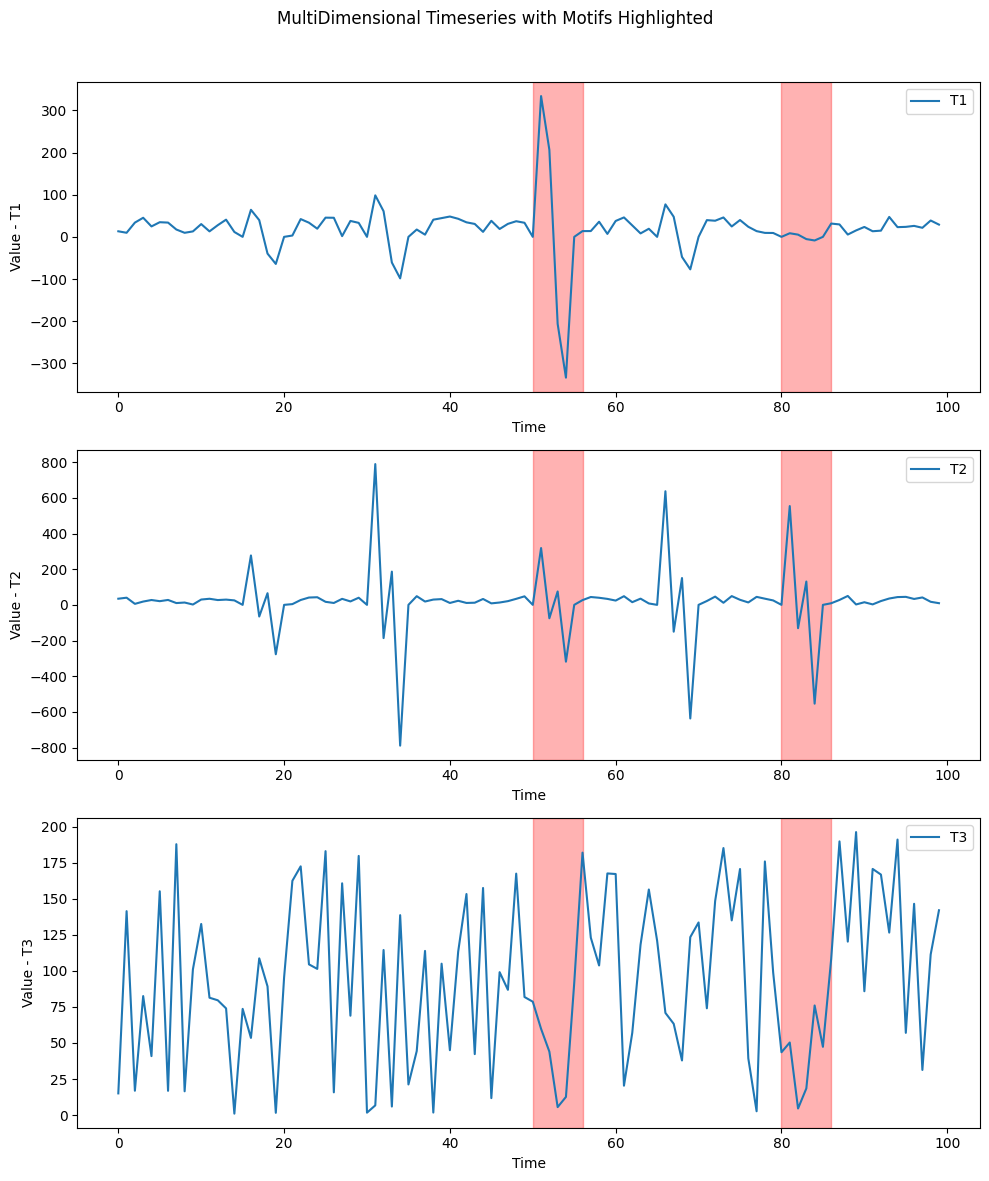

In [58]:
#@title Example 1

timeseries = np.random.rand(100) * 50
timeseries = timeseries.astype(float)

# Plant motifs at specific locations
motif_length = 6
motif = 4.5 * np.sin(np.linspace(0, 2 * np.pi, motif_length))

# Plant the motif at specific locations
motif_locations = [15, 30, 50, 65, 80]

for loc in motif_locations:
    motif_place = motif * np.random.randint(1, 100)
    timeseries[loc:loc+motif_length] = motif_place
# Create sample 3-dimensional timeseries
timeseries_3d = np.random.rand(100, 3) * 50
timeseries_3d[:, 0] = timeseries  # One dimension is the same as the unidimensional time series

# Plant motifs at specific locations in the second dimension
motif_length = 6
motif = 4.5 * np.tan(np.linspace(0, 2 * np.pi, motif_length))

# Plant the motif at specific locations in the second dimension
motif_locations = [15, 30, 50, 65, 80]

for loc in motif_locations:
    motif_place = motif * np.random.randint(1, 100)
    timeseries_3d[loc:loc+motif_length, 1] = motif_place

# The third dimension is just noise
timeseries_3d[:, 2] = np.random.rand(100)*200

# Set parameters
window_size = 6
lsh_threshold = 0.8
projection_iter = 3
k = 2

# Pick the subsequences where the motifs are located
rp = RandomDiscretizedProjections('rp', 10, 10)
engine = Engine(window_size, lshashes=[rp])

subsequences = []
for index in motif_locations:
    subsequences.append(timeseries_3d[index:index+window_size])
norm =  []
# Compute their z-normalization
for subsequence in subsequences:
    subsequence = (subsequence - np.mean(subsequence)) / np.std(subsequence)
    norm.append(subsequence)

# Compute the Jaccard similarity between the subsequences
jaccard_sim = np.zeros((len(subsequences), len(subsequences)))
for i, subsequence1 in enumerate(norm):
    for j, subsequence2 in enumerate(norm):
        # Find the intersection and union of the subsequences
        intersection = np.intersect1d(subsequence1, subsequence2)
        union = np.union1d(subsequence1, subsequence2)
        jaccard_sim[i, j] = len(intersection) / len(union)
        hash1 = np.apply_along_axis(euclidean_hash, 0 , subsequence1, rp)
        #print(hash1)


print(jaccard_sim)

# Find motifs
motifs, dist_comp = pmotif_find2(timeseries_3d, window_size, projection_iter, k, 2, 8, lsh_threshold, 1, 32)
motifs = motifs.queue
print(dist_comp)
# Plot the original time series and highlight the motifs, find the motifs in all the time series
df = pd.DataFrame(timeseries_3d, columns=['T1', 'T2', 'T3'])

# Plot 3 subplots, one for each dimension
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
colors = ["red", "green", "blue", "pink", "cyan", "yellow", "orange", "gray", "purple"]
for i, dimension in enumerate(['T1', 'T2', 'T3']):
    axs[i].plot(df[dimension], label=dimension)
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel(f"Value - {dimension}")
    axs[i].legend()

    for idx, motif in enumerate(motifs):
        # Highlight the motifs in all dimensions
        for m in motif[1][1]:
            axs[i].axvspan(m, m + window_size, color=colors[idx], alpha=0.3)

plt.suptitle("MultiDimensional Timeseries with Motifs Highlighted")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Hashing finished


Iteration:   5%|▌         | 1/20 [00:01<00:19,  1.00s/it]

COmputed len 1


Iteration:  10%|█         | 2/20 [00:01<00:17,  1.05it/s]

COmputed len 1


Iteration:  15%|█▌        | 3/20 [00:03<00:19,  1.14s/it]

COmputed len 1


Iteration:  20%|██        | 4/20 [00:05<00:26,  1.67s/it]

COmputed len 0


Iteration:  25%|██▌       | 5/20 [00:06<00:17,  1.17s/it]

COmputed len 0


Iteration:  30%|███       | 6/20 [00:06<00:12,  1.12it/s]

COmputed lenCOmputed len 0
 1


Iteration:  40%|████      | 8/20 [00:07<00:08,  1.37it/s]

COmputed len 0


Iteration:  45%|████▌     | 9/20 [00:08<00:08,  1.29it/s]

COmputed len 1


Iteration:  50%|█████     | 10/20 [00:08<00:06,  1.56it/s]

COmputed len 0


Iteration:  55%|█████▌    | 11/20 [00:10<00:08,  1.08it/s]

COmputed len 0


Iteration:  60%|██████    | 12/20 [00:10<00:06,  1.27it/s]

COmputed len 1


Iteration:  65%|██████▌   | 13/20 [00:13<00:08,  1.21s/it]

COmputed len 0
COmputed len

Iteration:  70%|███████   | 14/20 [00:13<00:05,  1.09it/s]

 0


Iteration:  80%|████████  | 16/20 [00:15<00:03,  1.09it/s]

COmputed len 0
COmputed len 0
COmputed len 0


Iteration:  90%|█████████ | 18/20 [00:16<00:01,  1.40it/s]

COmputed len 0


Iteration: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]

COmputed len 0
COmputed len 0
Len 6
6


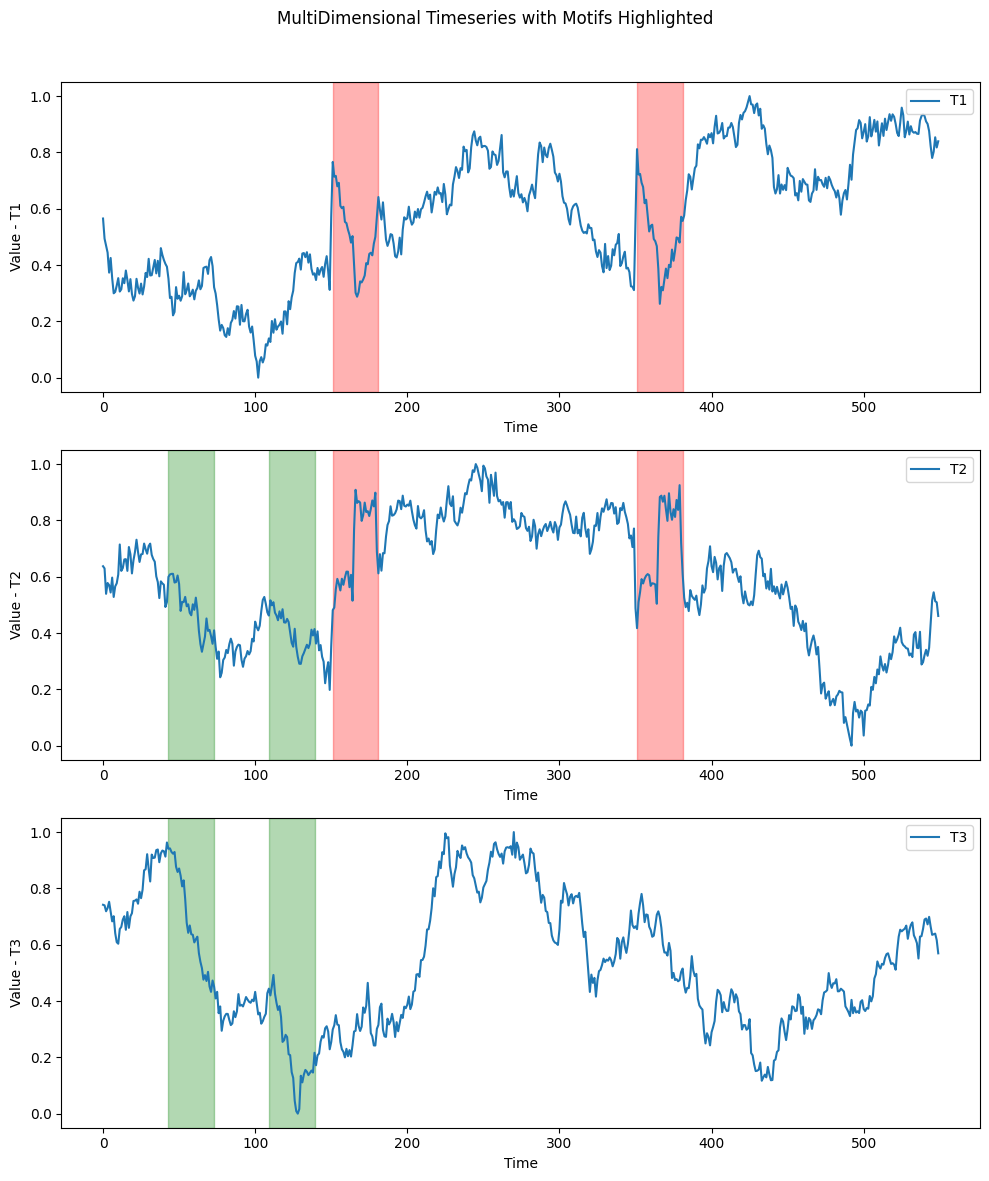

In [69]:
#@title Example 2 - Priority
import cProfile
df = pd.read_csv("https://zenodo.org/record/4328047/files/toy.csv?download=1")
ts_test = df.to_numpy()

# Set parameters
window_size = 30
lsh_threshold = 0.30
projection_iter = 3
k = 3
proj= 2
colors = ["red", "green", "blue", "pink", "cyan", "yellow", "orange", "gray", "purple", "gray", "hotpink", "lime"]


motifs, distance_comp = pmotif_find2(ts_test, window_size, projection_iter, k, proj, 10,lsh_threshold, 20, 16)
print(distance_comp)
motifs = motifs.queue
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
for i, dimension in enumerate(df.columns):
    axs[i].plot(df[dimension], label=dimension)
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel(f"Value - {dimension}")
    axs[i].legend()

    for idx, motif in enumerate(motifs):
        # Highlight the motifs in all dimensions
        for m in motif[1][1]:
          if i in motif[1][2][0]:
            axs[i].axvspan(m, m + window_size, color=colors[idx], alpha=0.3)

plt.suptitle("MultiDimensional Timeseries with Motifs Highlighted")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Stumpy

In [ ]:
if __name__ == "__main__":
    df = pd.read_csv("https://zenodo.org/record/4328047/files/toy.csv?download=1")
    #your_time_series = np.random.rand(10000)
    window_size = 30  # Approximately, how many data points might be found in a pattern
    #all_gpu_devices = [device.id for device in cuda.list_devices()]  # Get a list of all available GPU devices

    matrix_profile, matrix_profile_idx = stumpy.mstump(df, m=window_size)

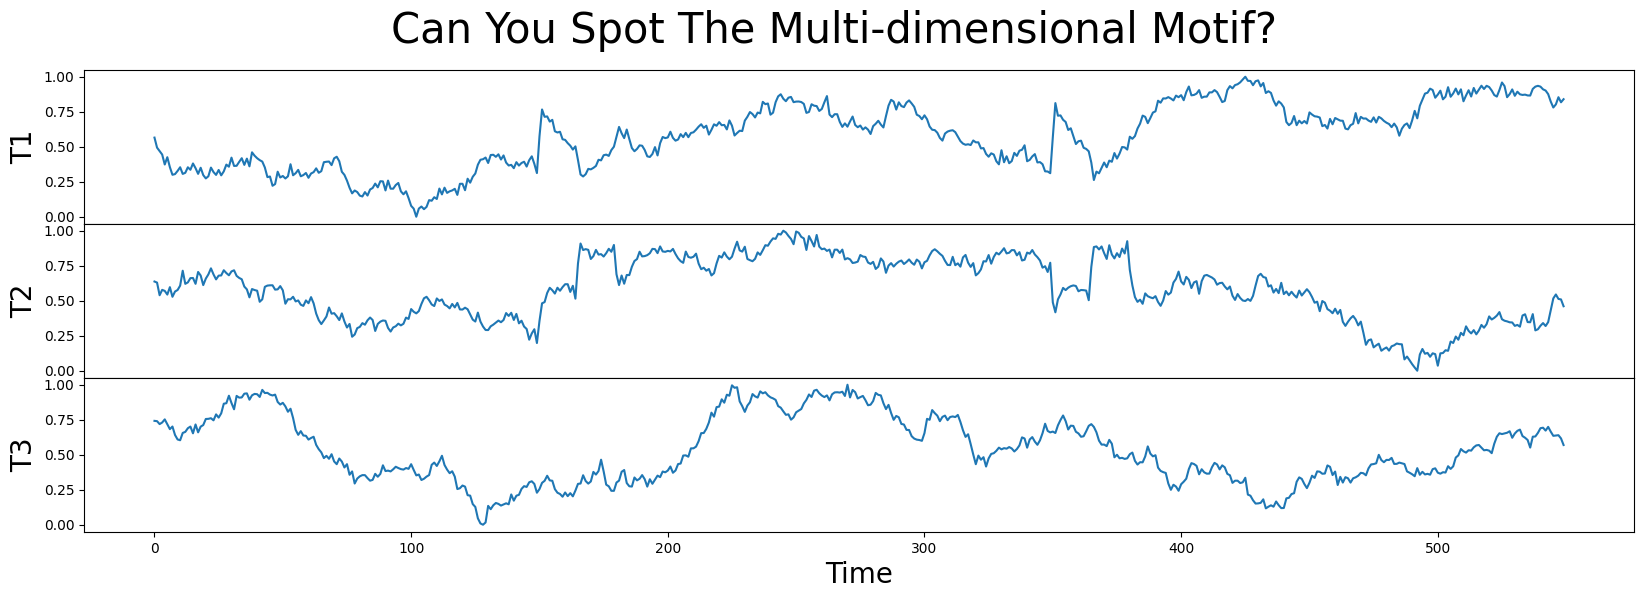

In [ ]:
fig, axs = plt.subplots(df.shape[1], sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Can You Spot The Multi-dimensional Motif?', fontsize='30')

for i in range(df.shape[1]):
    axs[i].set_ylabel(f'T{i + 1}', fontsize='20')
    axs[i].set_xlabel('Time', fontsize ='20')
    axs[i].plot(df[f'T{i + 1}'])

plt.show()

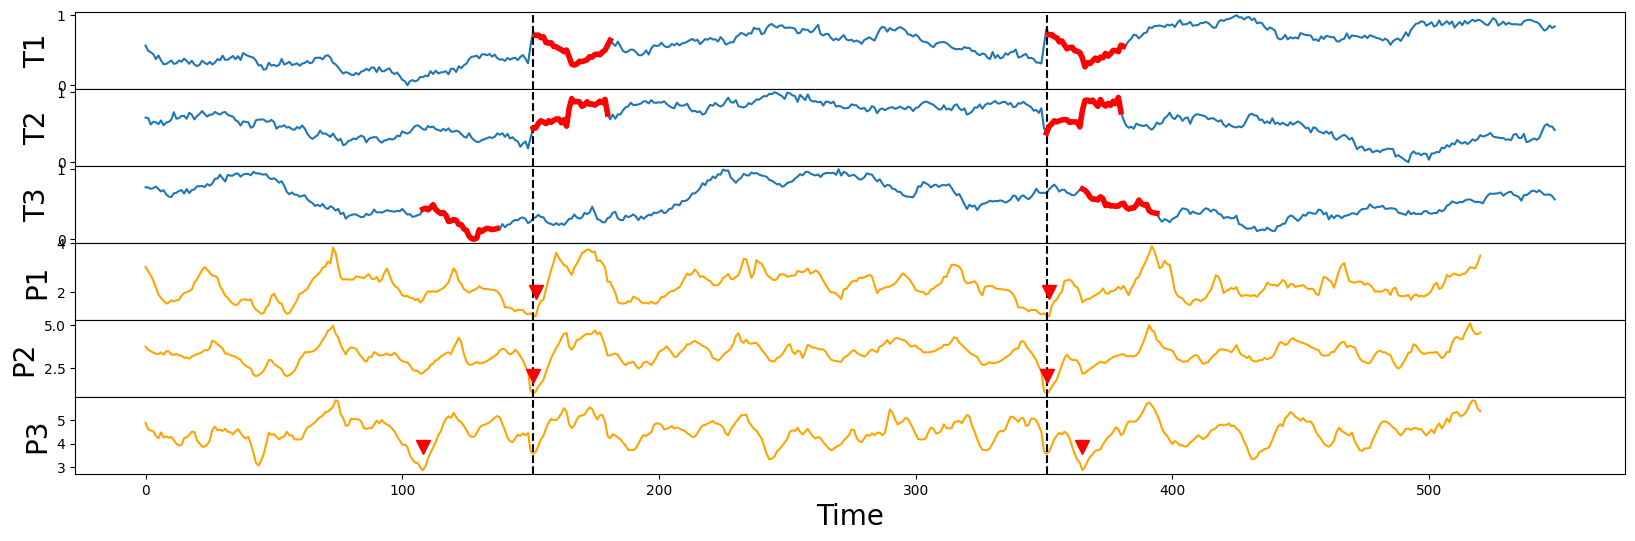

In [ ]:
motifs_idx = np.argmin(matrix_profile, axis=1)
nn_idx = matrix_profile_idx[np.arange(len(motifs_idx)), motifs_idx]
m = window_size
fig, axs = plt.subplots(matrix_profile.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0})

for k, dim_name in enumerate(df.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')

    axs[k + matrix_profile.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
    axs[k + matrix_profile.shape[0]].plot(matrix_profile[k], c='orange')
    axs[k + matrix_profile.shape[0]].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + matrix_profile.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + matrix_profile.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

    #if dim_name != 'T3':
    axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
    axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
    axs[k + matrix_profile.shape[0]].plot(motifs_idx[k], matrix_profile[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
    axs[k + matrix_profile.shape[0]].plot(nn_idx[k], matrix_profile[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')

plt.show()

#ATTIMO

In [ ]:
!pip install pyattimo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.3 MB/s eta 0:00:00


In [ ]:
import pyattimo

# Load an example time series
ts = pyattimo.load_dataset("ecg", prefix=1000000)

# Create the motifs iterator
motifs = pyattimo.MotifsIterator(ts, w=1000, max_k=100)

# Get the top motif via the iterator interface
m = next(motifs)

# Plot the motif just obtained
m.plot()

ModuleNotFoundError: No module named 'pyattimo'

#AEON data

In [ ]:
import os
!pip install aeon ucimlrepo
import aeon
from aeon.datasets import load_from_tsfile
from aeon.datasets import load_classification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 8.1 MB/s eta 0:00:00


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features
print(air_quality.metadata)

{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 'S. D. Vito, E. Massera, M. P

In [ ]:
X = X.iloc[:,2:]
matrix_profile, matrix_profile_idx = stumpy.mstump(X, m=30)

In [ ]:
X_p = X.fillna(0).values

In [ ]:
nan_columns = np.where(np.isnan(X_p).any(axis=0))[0]

# Check for NaN values along the rows (axis=1)
nan_rows = np.where(np.isnan(X_p).any(axis=1))[0]

print("Columns with NaN values:", nan_columns)
print("Rows with NaN values:", nan_rows)

Columns with NaN values: []
Rows with NaN values: []


In [ ]:
# Set parameters
window_size = 30
lsh_threshold = 0.80
projection_iter = 13
k = 3
proj= 2
colors = ["red", "green", "blue", "pink", "cyan", "yellow", "orange", "gray", "purple"]

#cProfile.run("pmotif_find2(X_p, window_size, projection_iter, k, proj, 10,lsh_threshold, 10, 32)")
motifs, distance_comp = pmotif_find2(X_p, window_size, projection_iter, k, proj, 10,lsh_threshold, 10, 32)
print(distance_comp)

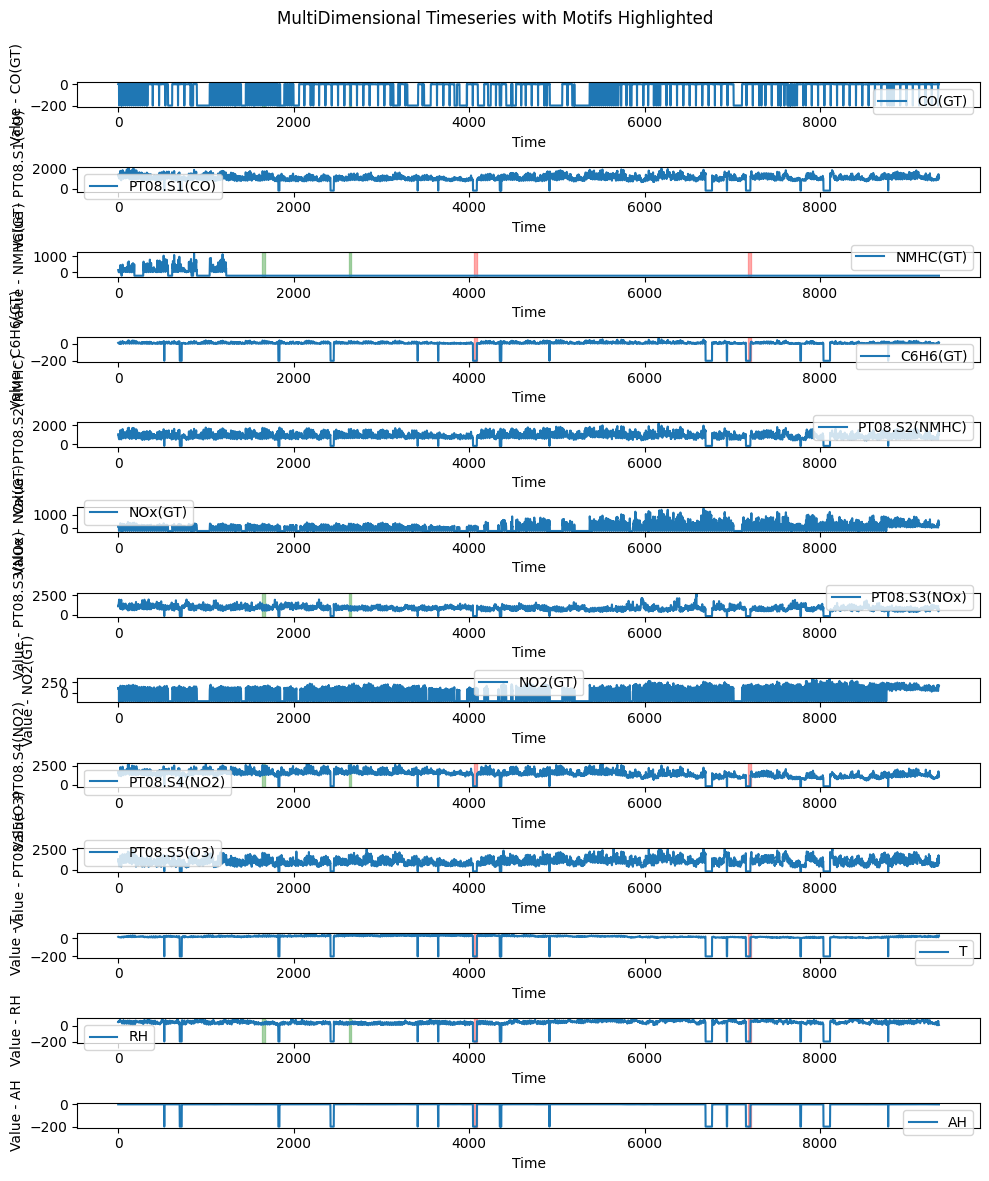

In [ ]:
motifs = motifs.queue
fig, axs = plt.subplots(13, 1, figsize=(10, 12))
for i, dimension in enumerate(X.columns):
    axs[i].plot(X[dimension], label=dimension)
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel(f"Value - {dimension}")
    axs[i].legend()

    for idx, motif in enumerate(motifs):
        # Highlight the motifs in all dimensions
        for m in motif[1][1]:
          if i in motif[1][2][0]:
            axs[i].axvspan(m, m + window_size, color=colors[idx], alpha=0.3)

plt.suptitle("MultiDimensional Timeseries with Motifs Highlighted")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

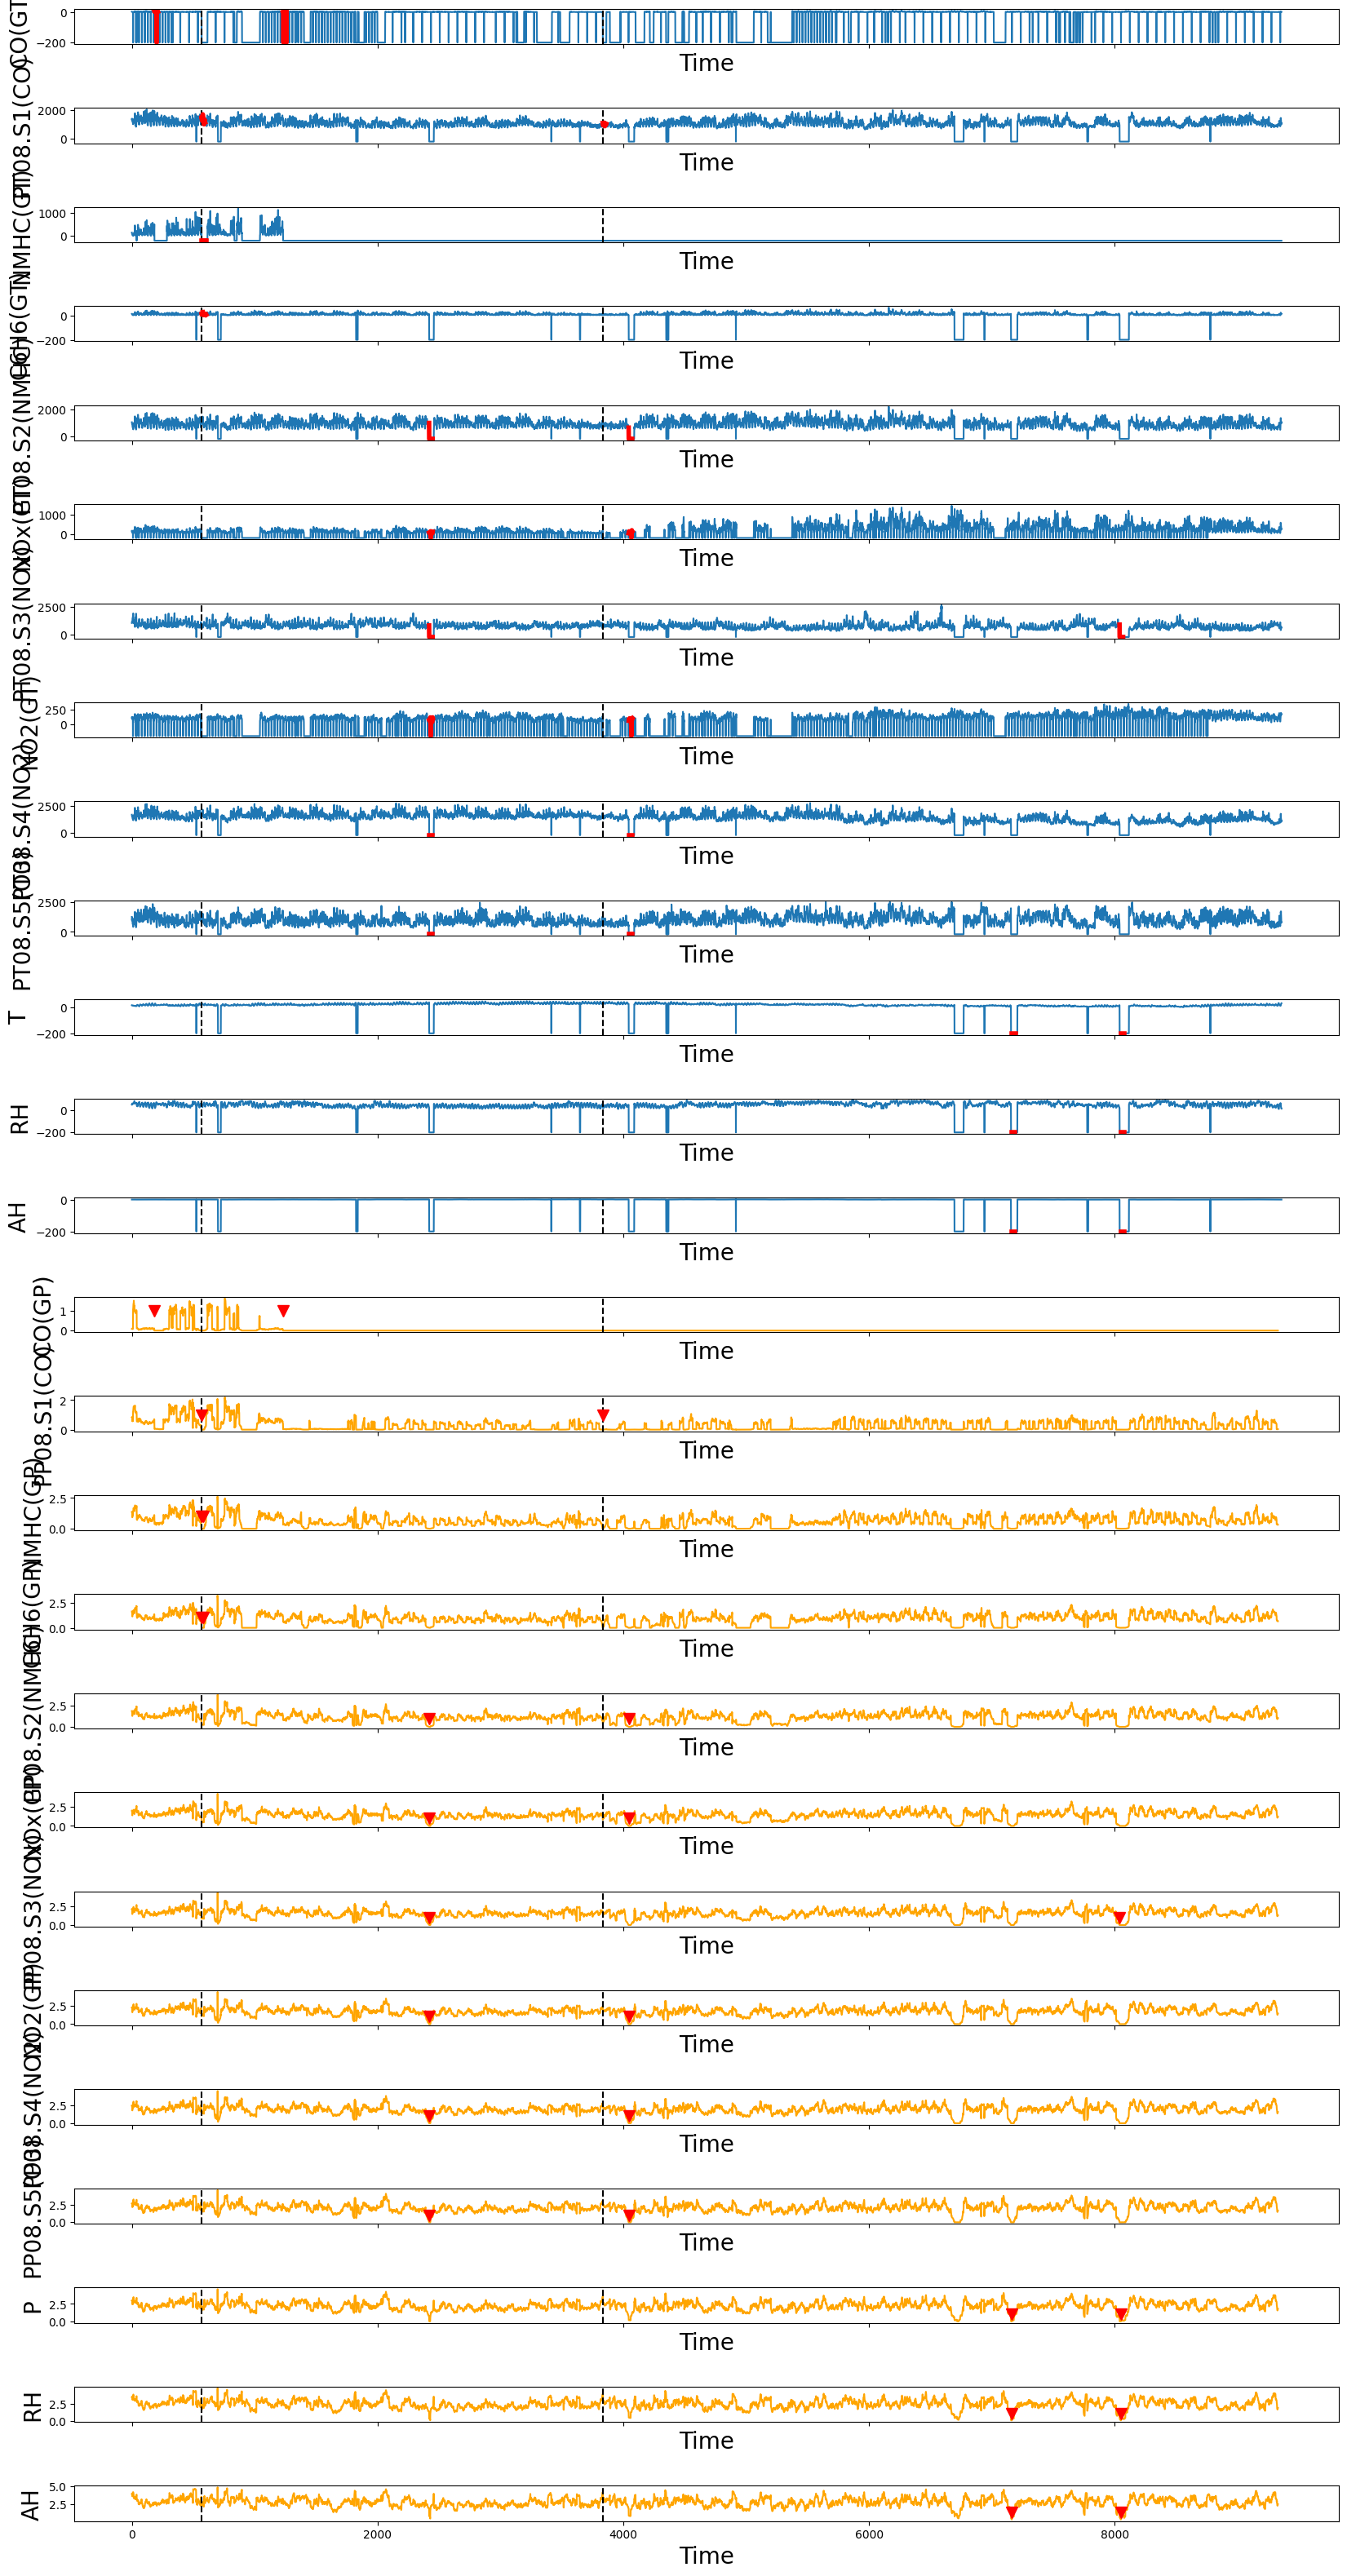

In [ ]:
motifs_idx = np.argmin(matrix_profile, axis=1)
nn_idx = matrix_profile_idx[np.arange(len(motifs_idx)), motifs_idx]
m = 30
fig, axs = plt.subplots(matrix_profile.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 1.8}, figsize=(20,40))

for k, dim_name in enumerate(X.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(X[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')

    axs[k + matrix_profile.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
    axs[k + matrix_profile.shape[0]].plot(matrix_profile[k], c='orange')
    axs[k + matrix_profile.shape[0]].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + matrix_profile.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + matrix_profile.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

    #if dim_name != 'T3':
    axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), X[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
    axs[k].plot(range(nn_idx[k], nn_idx[k] + m), X[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
    axs[k + matrix_profile.shape[0]].plot(motifs_idx[k], matrix_profile[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
    axs[k + matrix_profile.shape[0]].plot(nn_idx[k], matrix_profile[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')

plt.show()